## Library Import

In [1]:
import matplotlib.pyplot as plt # General plotting
import matplotlib as mpl # General Plotting
from IPython.display import display # Plot display
import yfinance as yf # Data imports using Yahoo Finance
from statsmodels.tsa.stattools import adfuller # ADF evaluaiton
import os # For  file path handling
import glob # For  file path handling

# Import custom functions and classes
from ScenarioGenerationOptimization import PortfolioOptimizer
from ScenarioGenerationOptimization import ScenarioGenerator
import ScenarioGenerationOptimization as sgo



# For dataframe and array handling
import numpy as np
import pandas as pd

# For risk-free rate calculations
from fredapi import Fred
#fred = Fred(api_key='YOUR API KEY')
fred = Fred(api_key='11a8de5271a9577d2518ffc0f5c33be4')



## 1. Data Download

Includes portfolio selection as well as volatility and Dow index

In [2]:
dow_unchanged = [
    "AXP",  # American Express
    "BA",   # Boeing
    "CAT",  # Caterpillar
    "HD",   # Home Depot
    "JNJ",  # Johnson & Johnson
    "JPM",  # JPMorgan Chase
    "KO",   # Coca-Cola
    "MCD",  # McDonald's
    "PG"    # Procter & Gamble
]

# Set start and end dates for study
full_start_date = "2005-01-01"
full_end_date   = "2025-01-01"

# Download data using Yahoo Finance
print("Downloading historical data for Dow Unchanged stocks...")
data = {symbol: yf.download(symbol, start=full_start_date, end=full_end_date, progress=False)['Close']
        for symbol in dow_unchanged}

log_returns = {symbol: sgo.compute_log_returns(data[symbol]) for symbol in dow_unchanged}
returns = pd.concat(log_returns, axis=1)
returns.columns = returns.columns.get_level_values(0)

# Get Number of observations
print("Total trading Days:", returns.shape[0],"; Total trading years:", np.round(returns.shape[0] / 252,2))

##########################################################################
# 1. b. Download DJIA and VXD Data for Volatility Regime Classification  #
##########################################################################
print("Downloading DJIA and VXD data...")
# Import DJIA Index from Yahoo Finance
djia = yf.download("^DJI", start=full_start_date, end=full_end_date, progress=False)['Close']

# Import VXD Index from FRED and Yahoo Finance
vxd_yf = yf.download("^VXD", start=full_start_date, end=full_end_date, progress= False)
fred = Fred(api_key='11a8de5271a9577d2518ffc0f5c33be4')
vxd_fred = fred.get_series("VXDCLS")

# Crop VXD to the same date range as DJIA
vxd_fred = vxd_fred.loc[djia.index.min():vxd_yf.index.min()]

# Merge VXD from Yahoo Finance and VXD from FRED in respective order
vxd = pd.concat([vxd_yf['Close'], vxd_fred], axis=1)
vxd['^VXD'] = vxd['^VXD'].combine_first(vxd[0][:-1])
vxd.drop(columns=[0], inplace=True)
vxd_series = vxd['^VXD'].dropna()
vxd_series_interpolated = vxd_series.interpolate(method='linear') # Interpolate for missing values


YF.download() has changed argument auto_adjust default to True
Total trading Days: 5032 ; Total trading years: 19.97


## 2. Training, Validation and Testing split

In [3]:
##############################################
# 2. Split Data into Training and Testing Sets
##############################################
returns_train = returns[:-252]
returns_test = returns[-252:]
print(returns_train.shape[0], "days in Training Split")
print(returns_test.shape[0], "days in Testing Split")

4780 days in Training Split
252 days in Testing Split


## 3. Exploratory Analysis

In [4]:
# Generate summary statistics for train data
print("Training data summary statistics:")
summary_stats = returns_train.describe().T
summary_stats['skew'] = returns_train.skew()
summary_stats['kurtosis'] = returns_train.kurtosis()
display(summary_stats.T)


Training data summary statistics:


,AXP,BA,CAT,HD,JNJ,JPM,KO,MCD,PG
count,4780.000000,4780.000000,4780.000000,4780.000000,4780.000000,4780.000000,4780.000000,4780.000000,4780.000000
mean,0.000341,0.000416,0.000485,0.000533,0.000304,0.000415,0.000338,0.000576,0.000315
std,0.022449,0.022098,0.020087,0.016604,0.010815,0.023114,0.011573,0.012699,0.011457
min,-0.193524,-0.272444,-0.156859,-0.220570,-0.105782,-0.232278,-0.101728,-0.172871,-0.091429
25%,-0.007711,-0.009282,-0.009044,-0.007194,-0.004556,-0.008318,-0.004843,-0.005488,-0.004812
50%,0.000467,0.000710,0.000661,0.000674,0.000227,0.000321,0.000498,0.000830,0.000416
75%,0.009424,0.010463,0.010612,0.008428,0.005649,0.009100,0.005807,0.006740,0.005864
max,0.197885,0.217677,0.137350,0.131613,0.115373,0.223918,0.129971,0.166577,0.113409
skew,0.209052,-0.353681,-0.259003,-0.331174,-0.004433,0.268957,-0.169153,-0.027790,-0.092047
kurtosis,14.145659,17.620338,5.472600,12.292915,11.582369,17.704073,12.194622,19.064450,10.041761


### Stationarity Tests

In [5]:
# Initialize an empty list to store the results
adf_results = []

# Loop through each column in returns_train
for column in returns_train.columns:
    # Perform the ADF test
    result = adfuller(returns_train[column],maxlag = 252)
    
    # Store the results in a dictionary
    adf_result = {
        'Ticker': column,
        'ADF Statistic': result[0],
        'p-value': result[1],
        '1% Critical Value': result[4]['1%'],
    }
    
    # Append the dictionary to the results list
    adf_results.append(adf_result)

# Convert the results list to a DataFrame
adf_results_df = pd.DataFrame(adf_results)

# Display the results
display(adf_results_df)

,Ticker,ADF Statistic,p-value,1% Critical Value
0,AXP,-5.610368,1.207377e-06,-3.431754
1,BA,-10.193850,6.220376e-18,-3.431735
2,CAT,-16.160220,4.473936e-29,-3.431724
3,HD,-23.765272,0.000000e+00,-3.431721
4,JNJ,-18.234528,2.362904e-30,-3.431724
5,JPM,-8.120364,1.160497e-12,-3.431747
6,KO,-30.285356,0.000000e+00,-3.431721
7,MCD,-16.132109,4.773260e-29,-3.431725
8,PG,-22.779435,0.000000e+00,-3.431721


C:\Users\stefa\AppData\Local\Temp\ipykernel_25472\2176115119.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap('cividis')


Correlation Analysis:
    Comparison  Max CCF Lag  Max CCF Value  CCF Value at Lag 0
0  DJIA vs VXD            4       0.843085            0.804168
1   EWP vs VXD            4       0.830304            0.785305
2  DJIA vs EWP            0       0.974730            0.974730


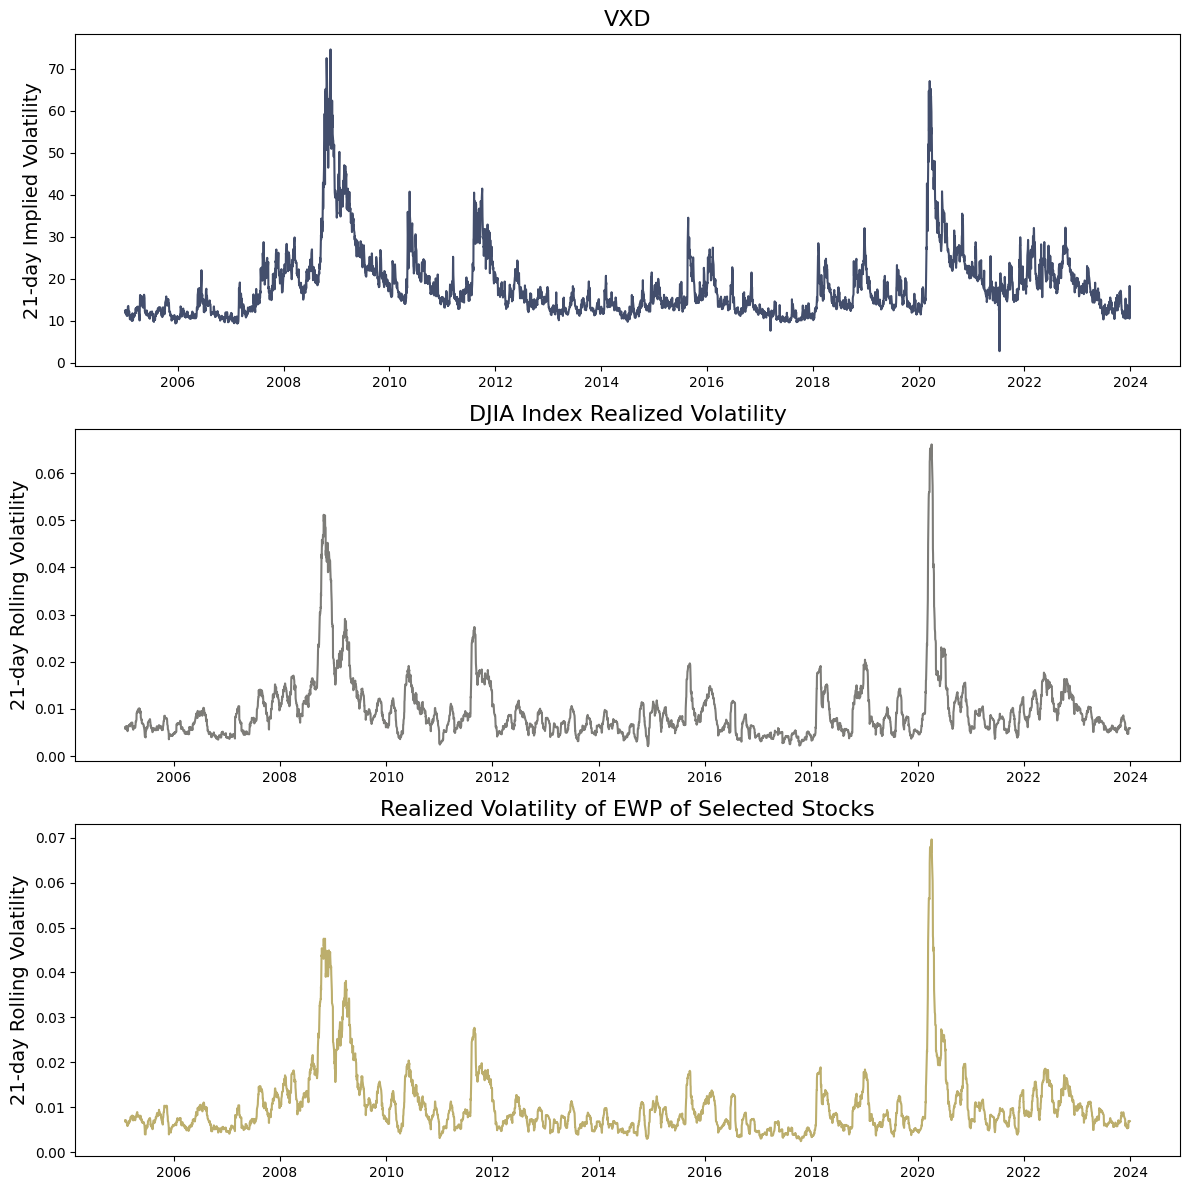

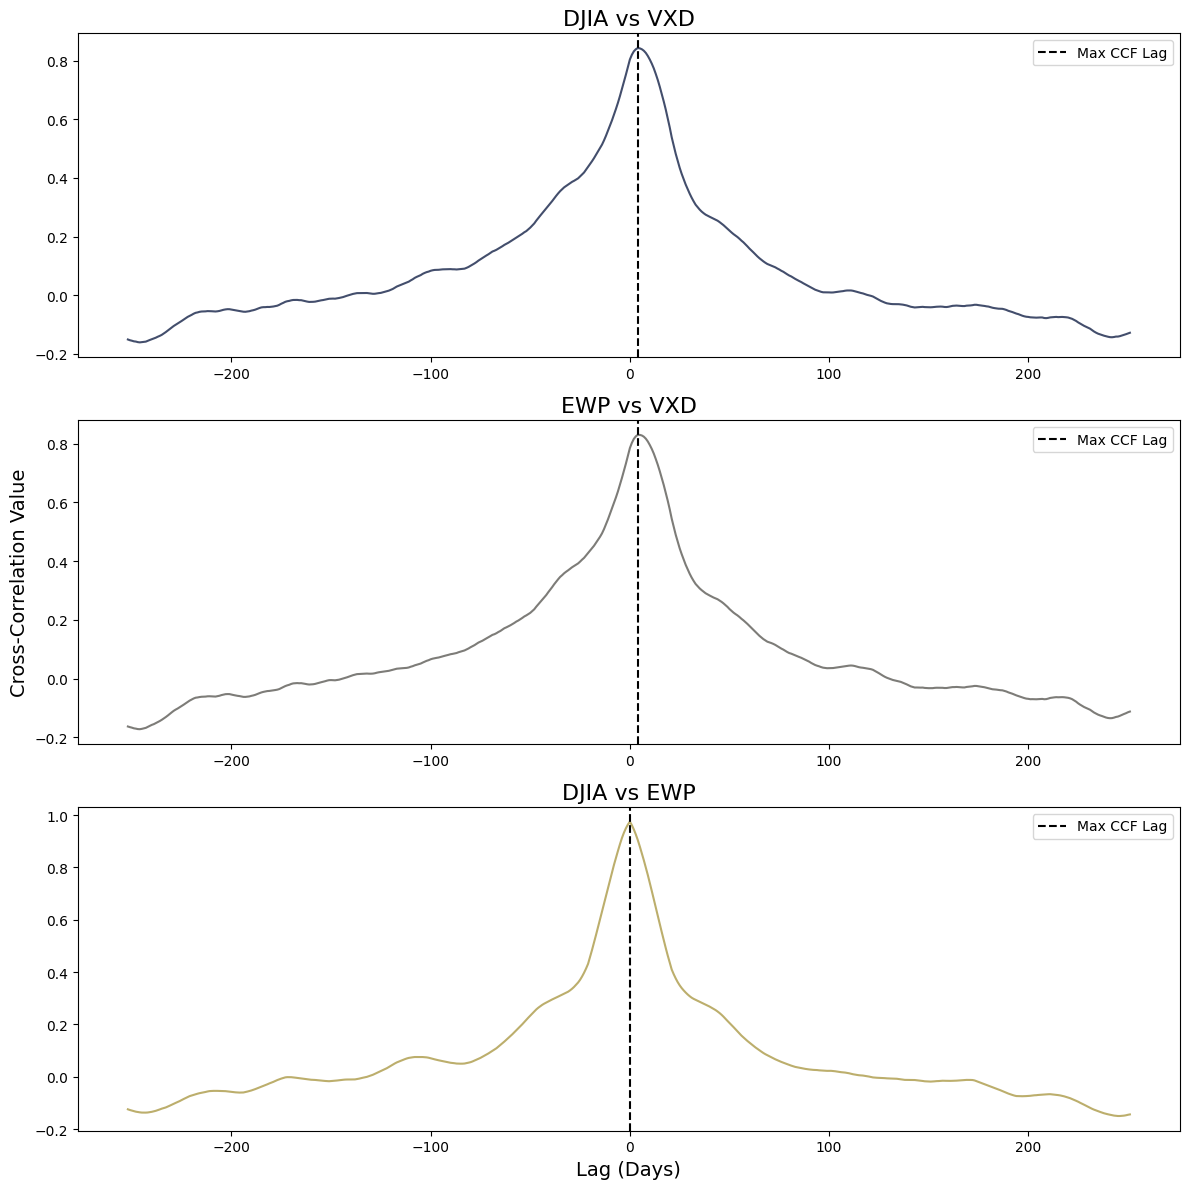

In [7]:
# Set a colorblind friendly color map
cmap = mpl.cm.get_cmap('cividis')
col_1,col_2,col_3 = cmap(0.25), cmap(0.5), cmap(0.75)

# Correlation Analysis
print("Correlation Analysis:")

# Compute variance time series for DJIA, VXDCLS, and EWP

# Compute Log-Returns for DJIA and rolling volatility
djia_returns = np.log(djia/ djia.shift(1)).dropna()
djia_variance_series = djia_returns.rolling(window=21).std()

# Ensure alignment of both DJIA and VXDCLS

# Find the dates in the index of djia_variance_series that are not in vxd_series_interpolated_aligned
missing_dates = djia_variance_series.index.difference(vxd_series_interpolated.index)
# Add missing dates to vxd_series_interpolated_aligned and interpolate their values
for date in missing_dates:
    vxd_series_interpolated.loc[date] = np.nan

vxd_series_interpolated = vxd_series_interpolated.sort_index().interpolate(method='linear')

# Compute Log-Returns of EWP and rolling volatility
equal_weighted_returns = returns_train.mean(axis=1)
returns_variance_series = equal_weighted_returns.rolling(window=21).std()

# Create the figure and axes
fig, ax = plt.subplots(3, 1, figsize=(12, 12))

# Plot the VXD time series
ax[0].plot(vxd_series_interpolated[:-252], color=col_1, linestyle='-', linewidth=1.5)
ax[0].set_title('VXD', fontsize=16)
ax[0].set_ylabel('21-day Implied Volatility', fontsize=14)


# Plot the volatility time series for DJIA
ax[1].plot(djia_variance_series[:-252], color=col_2, linestyle='-', linewidth=1.5)
ax[1].set_title('DJIA Index Realized Volatility', fontsize=16)
ax[1].set_ylabel('21-day Rolling Volatility', fontsize=14)


# Plot the EWP time series
ax[2].plot(returns_variance_series, color= col_3 , linestyle='-', linewidth=1.5)
ax[2].set_title('Realized Volatility of EWP of Selected Stocks', fontsize=16)
ax[2].set_ylabel('21-day Rolling Volatility', fontsize=14)


# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig('volatility_analysis.png', dpi=300, bbox_inches='tight')
# Drop NaN values generated from rolling forecast and align the three series
djia_variance_series_aligned = djia_variance_series.dropna()[:-252].squeeze()
vxd_series_interpolated_aligned = vxd_series_interpolated[21:-252]
returns_variance_series = returns_variance_series.dropna()

# Compute deconstructed stationary versions of our series
djia_variance_series_stat= sgo.make_stationary(djia_variance_series_aligned)[252:]
vxd_series_interpolated_stat = sgo.make_stationary(vxd_series_interpolated_aligned)[252:]
returns_variance_stat = sgo.make_stationary(returns_variance_series)[252:]


# Create the figure and axes
fig, ax = plt.subplots(3, 1, figsize=(12, 12))

# Compare CCF of DJIA Realized Volatility and VXD
ccf_norm, lags = sgo.compute_normalized_ccf(djia_variance_series_stat, vxd_series_interpolated_stat)
max_location = np.argmax(ccf_norm)
mid_point = len(lags) // 2
results = []
results.append(['DJIA vs VXD', lags[max_location], ccf_norm[max_location], ccf_norm[len(lags) // 2]])
ax[0].plot(lags[mid_point-252:mid_point+252], ccf_norm[mid_point-252:mid_point+252], color=col_1)
ax[0].axvline(lags[max_location], color='black', linestyle='--', label='Max CCF Lag')

ax[0].set_title('DJIA vs VXD', fontsize=16)
ax[0].legend()

# Compare CCF of EWP and VXD
ccf_norm, lags = sgo.compute_normalized_ccf(returns_variance_stat, vxd_series_interpolated_stat)
max_location = np.argmax(ccf_norm)
mid_point = len(lags) // 2
results.append(['EWP vs VXD', lags[max_location], ccf_norm[max_location], ccf_norm[len(lags) // 2]])
ax[1].plot(lags[mid_point-252:mid_point+252], ccf_norm[mid_point-252:mid_point+252], color=col_2)
ax[1].axvline(lags[max_location], color='black', linestyle='--', label='Max CCF Lag')
ax[1].set_title('EWP vs VXD', fontsize=16)
ax[1].set_ylabel('Cross-Correlation Value', fontsize=14)

ax[1].legend()

# Compute CCF between DJIA and EWP
ccf_norm, lags = sgo.compute_normalized_ccf(djia_variance_series_stat, returns_variance_stat)
max_location = np.argmax(ccf_norm)
mid_point = len(lags) // 2
results.append(['DJIA vs EWP', lags[max_location], ccf_norm[max_location], ccf_norm[len(lags) // 2]])
ax[2].plot(lags[mid_point-252:mid_point+252], ccf_norm[mid_point-252:mid_point+252], color=col_3)
ax[2].axvline(lags[max_location], color='black', linestyle='--', label='Max CCF Lag')
ax[2].set_title('DJIA vs EWP', fontsize=16)

ax[2].set_xlabel('Lag (Days)', fontsize=14)
ax[2].legend()

# Adjust layout
plt.tight_layout()
plt.savefig('ccf_analysis.png', dpi=300, bbox_inches='tight')
# Generate table
results_df = pd.DataFrame(results, columns=['Comparison', 'Max CCF Lag', 'Max CCF Value', 'CCF Value at Lag 0'])
print(results_df)

## 3. Bootstrap Volatility Algorithm

In [8]:
# GET vxd_train values for train dates
vxd_train = vxd_series_interpolated[:-252]

# Compute Quantile Values
lower_quantile = vxd_train.quantile(0.5).item()
upper_quantile = vxd_train.quantile(0.9).item()
print("Lower Quantile (Median):", np.round(lower_quantile, 4))
print("Upper Quantile (90th percentile):", np.round(upper_quantile, 4))

Lower Quantile (Median): 15.73
Upper Quantile (90th percentile): 26.76


In [9]:
# Run the bootstrap simulation
time_stamps = sgo.sample_periodic_volatility(vxd_train, 15, lower_quantile, upper_quantile,random_state = 30)

# Convert the time_stamps dictionary to a DataFrame
time_stamps_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in time_stamps.items()]))
# Display the DataFrame
display(time_stamps_df)


Simulating...
Simulation complete!


,low_volatility_dates,medium_volatility_dates,high_volatility_dates
0,263,3885,919
1,163,1155,807
2,62,1042,888
3,2315,3430,837
4,186,3462,716
5,1870,4269,738
6,423,2575,943
7,3177,3853,974
8,1946,4018,764
9,2907,673,3749


15.729999542236328 26.760000228881836


,Simulation,Low Volatility Mean,Medium Volatility Mean,High Volatility Mean
0,1,12.15,23.35,36.99
1,2,12.53,21.04,33.61
2,3,11.93,25.15,36.80
3,4,13.64,16.94,35.35
4,5,12.48,17.38,25.40
5,6,14.20,22.42,28.52
6,7,13.32,17.32,36.47
7,8,14.38,25.32,32.36
8,9,13.61,18.46,30.81
9,10,12.28,21.03,28.43


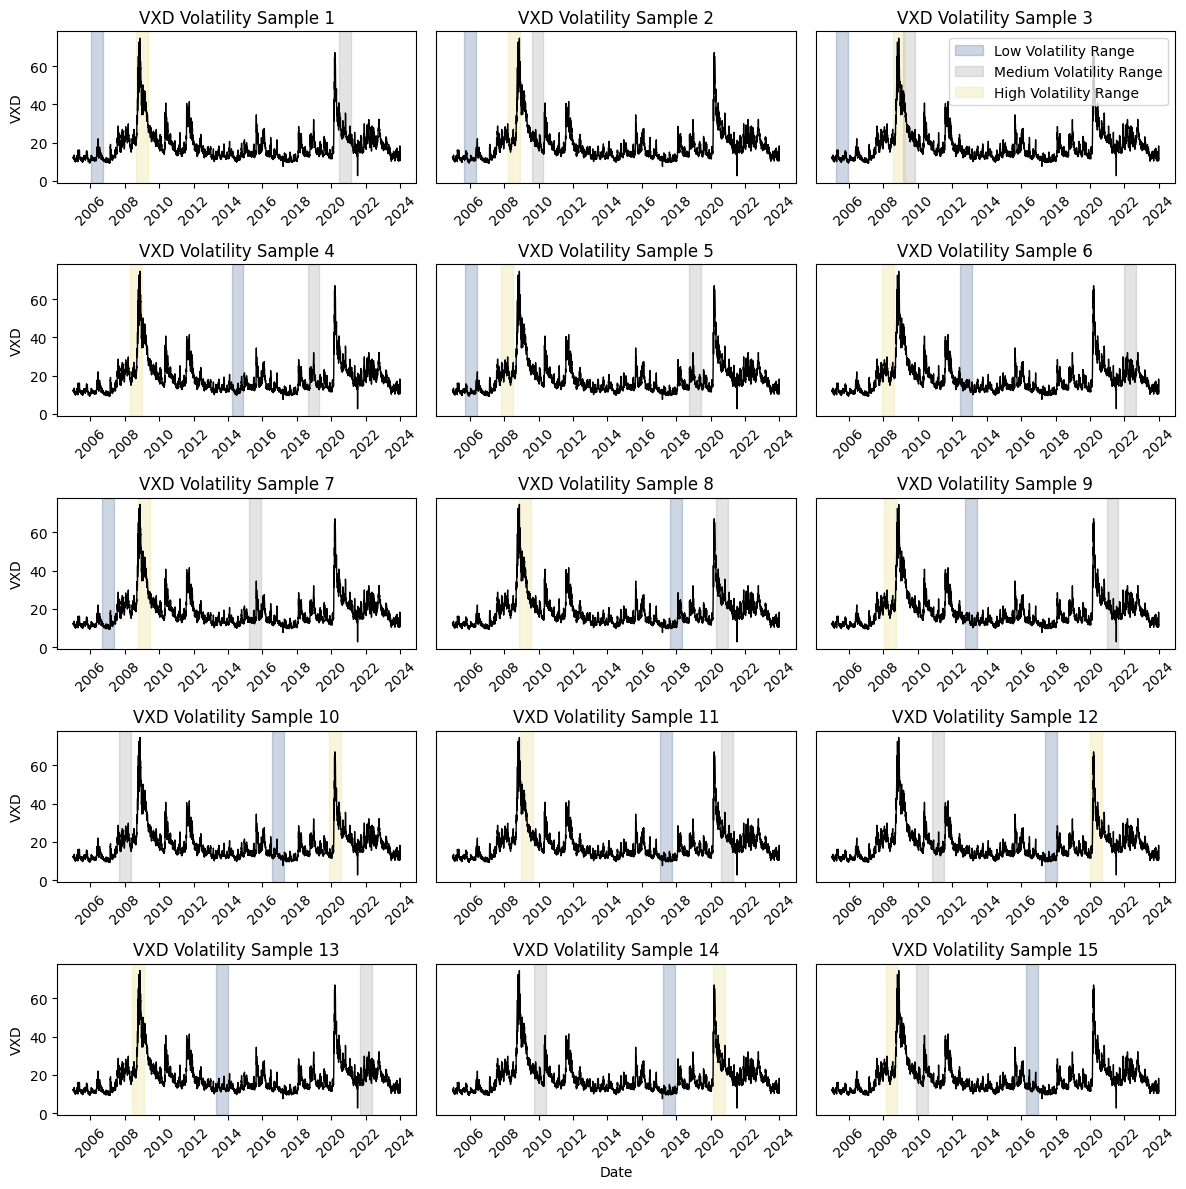

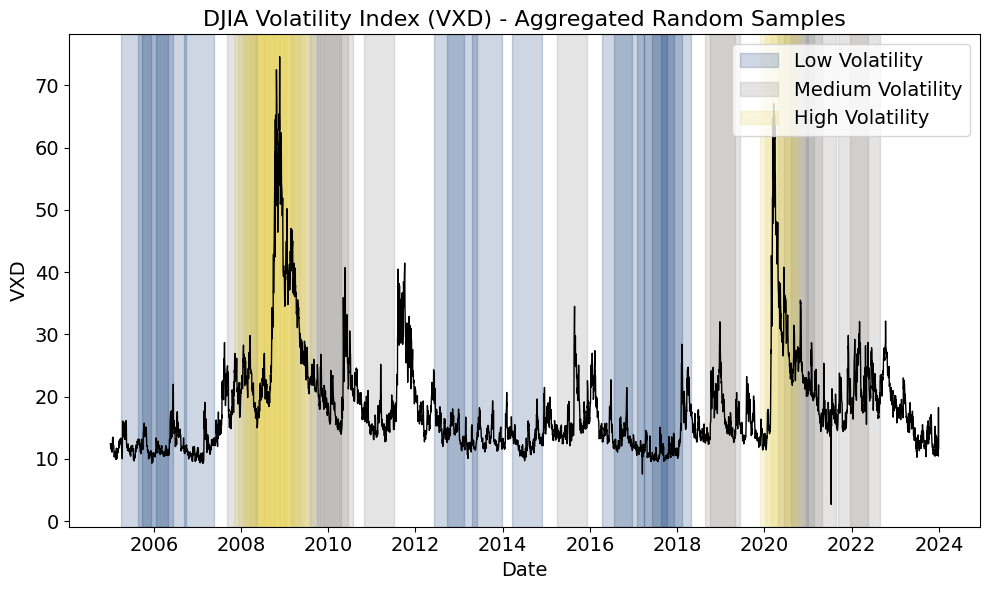

In [36]:
print(lower_quantile, upper_quantile)

col_1,col_2,col_3 = cmap(0.1), cmap(0.5), cmap(0.9)
# Create a 5x2 grid of subplots
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(12, 12))

# Flatten the axes array to easily index it
axes = axes.flatten()

# Loop through the simulations and plot each on a separate subplot
for i in range(15):
    ax = axes[i]  # Select the subplot for this iteration
    
    # Plot the VXD line on the current subplot
    ax.plot(vxd_train, color='black', linewidth=1)
    
    # Shade the quantile ranges with low alpha
    
    ax.axvspan(vxd_train.index[time_stamps['low_volatility_dates'][i]], 
               vxd_train.index[time_stamps['low_volatility_dates'][i]] + pd.Timedelta(days=252), 
               color=col_1, alpha=0.2, label='Low Volatility Range')
    
    ax.axvspan(vxd_train.index[time_stamps['medium_volatility_dates'][i]], 
               vxd_train.index[time_stamps['medium_volatility_dates'][i]] + pd.Timedelta(days=252), 
               color=col_2, alpha=0.2, label='Medium Volatility Range')
    
    ax.axvspan(vxd_train.index[time_stamps['high_volatility_dates'][i]], 
               vxd_train.index[time_stamps['high_volatility_dates'][i]] + pd.Timedelta(days=252), 
               color=col_3, alpha=0.2, label='High Volatility Range')
    
    # Calculate and print the mean value of vxd_series at each time_stamp period
    low_vol_mean = vxd_train[time_stamps['low_volatility_dates'][i]:time_stamps['low_volatility_dates'][i] + 252].mean()
    med_vol_mean = vxd_train[time_stamps['medium_volatility_dates'][i]:time_stamps['medium_volatility_dates'][i] + 252].mean()
    high_vol_mean = vxd_train[time_stamps['high_volatility_dates'][i]:time_stamps['high_volatility_dates'][i] + 252].mean()
    
    # Labels and title for each subplot
    ax.set_title(f"VXD Volatility Sample {i+1}")
    if i == 2:
        ax.legend(loc='upper right')
    if i == 13:
        ax.set_xlabel("Date")
    if i % 3 == 0:
        ax.set_ylabel("VXD")
    else:
        ax.set_yticks([])
    # Rotate x-axis date labels by 45 degrees
    ax.tick_params(axis='x', rotation=45)
# Adjust layout to make sure everything fits well
plt.tight_layout()

# Show the plot
plt.savefig('volind.png', dpi=300, bbox_inches='tight')


# Create the figure and axes object
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the VXD line once
ax.plot(vxd_train, color='black', linewidth=1)

# Loop through the simulation results and plot shaded regions
for i in range(15):
    if i == 0:
        # Shade the quantile ranges with low alpha
        
        
        ax.axvspan(vxd_train.index[time_stamps['low_volatility_dates'][i]], 
                vxd_train.index[time_stamps['low_volatility_dates'][i]] + pd.Timedelta(days=252), 
                color=col_1, alpha=0.2, label='Low Volatility')
        
        ax.axvspan(vxd_train.index[time_stamps['medium_volatility_dates'][i]], 
                vxd_train.index[time_stamps['medium_volatility_dates'][i]] + pd.Timedelta(days=252), 
                color=col_2, alpha=0.2, label='Medium Volatility')
        
        ax.axvspan(vxd_train.index[time_stamps['high_volatility_dates'][i]], 
                vxd_train.index[time_stamps['high_volatility_dates'][i]] + pd.Timedelta(days=252), 
                color=col_3, alpha=0.2, label='High Volatility')
    else:
        # Shade the quantile ranges with low alpha
        ax.axvspan(vxd_train.index[time_stamps['medium_volatility_dates'][i]], 
                vxd_train.index[time_stamps['medium_volatility_dates'][i]] + pd.Timedelta(days=252), 
                color=col_2, alpha=0.2)
        
        ax.axvspan(vxd_train.index[time_stamps['low_volatility_dates'][i]], 
                vxd_train.index[time_stamps['low_volatility_dates'][i]] + pd.Timedelta(days=252), 
                color=col_1, alpha=0.2)
        
        ax.axvspan(vxd_train.index[time_stamps['high_volatility_dates'][i]], 
                vxd_train.index[time_stamps['high_volatility_dates'][i]] + pd.Timedelta(days=252), 
                color=col_3, alpha=0.2)
    
# Labels and title
ax.set_title("DJIA Volatility Index (VXD) - Aggregated Random Samples", fontsize = 16)
ax.set_xlabel("Date", fontsize = 14)
ax.set_ylabel("VXD", fontsize = 14)
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.legend(loc='upper right', fontsize = 14)
# Ensure layout is tight
plt.tight_layout()

# Show the plot
plt.savefig('voloverlap.png', dpi=300, bbox_inches='tight')

# Create a DataFrame to store the mean values for each simulation
mean_values_df = pd.DataFrame({
    'Simulation': range(1, 16),
    'Low Volatility Mean': [round(vxd_train[time_stamps['low_volatility_dates'][j]:time_stamps['low_volatility_dates'][j] + 252].mean(), 2) for j in range(15)],
    'Medium Volatility Mean': [round(vxd_train[time_stamps['medium_volatility_dates'][j]:time_stamps['medium_volatility_dates'][j] + 252].mean(), 2) for j in range(15)],
    'High Volatility Mean': [round(vxd_train[time_stamps['high_volatility_dates'][j]:time_stamps['high_volatility_dates'][j] + 252].mean(), 2) for j in range(15)]
})

# Print the DataFrame
display(mean_values_df)

## 5. Split Training Data into Sub-Training and Validation sets according to volatility splits

In [12]:

##############################################
# 5. Split Training Data into Simulation Periods per Volatility Regime
##############################################
low_vol_train_list = []
low_vol_val_list = []
med_vol_train_list = []
med_vol_val_list = []
high_vol_train_list = []
high_vol_val_list = []

for i in range(len(time_stamps['low_volatility_dates'])):

    # Volatility Training sets 252 days long equivalent to 1 year of trading

    low_vol_train = returns_train[time_stamps['low_volatility_dates'][i]:time_stamps['low_volatility_dates'][i] + 252]
    med_vol_train = returns_train[time_stamps['medium_volatility_dates'][i]:time_stamps['medium_volatility_dates'][i] + 252]
    high_vol_train = returns_train[time_stamps['high_volatility_dates'][i]:time_stamps['high_volatility_dates'][i] + 252]
    
    low_vol_train_list.append(low_vol_train)
    med_vol_train_list.append(med_vol_train)
    high_vol_train_list.append(high_vol_train)

    # Volatility Validation sets 21 days long equivalent to 1 month of trading

    low_vol_val = returns_train[time_stamps['low_volatility_dates'][i] + 252 : time_stamps['low_volatility_dates'][i] + 273]
    med_vol_val = returns_train[time_stamps['medium_volatility_dates'][i] + 252 :time_stamps['medium_volatility_dates'][i] + 273]
    high_vol_val = returns_train[time_stamps['high_volatility_dates'][i] + 252 :time_stamps['high_volatility_dates'][i] + 273]
    
    low_vol_val_list.append(low_vol_val)
    med_vol_val_list.append(med_vol_val)
    high_vol_val_list.append(high_vol_val)

print("Low Volatility simulation periods:", len(low_vol_train_list))
print("Medium Volatility simulation periods:", len(med_vol_train_list))
print("High Volatility simulation periods:", len(high_vol_train_list))

# Organize regimes into dictionaries for ease of use.
regime_train = {'low': low_vol_train_list, 'medium': med_vol_train_list, 'high': high_vol_train_list}
regime_val = {'low': low_vol_val_list, 'medium': med_vol_val_list, 'high': high_vol_val_list}




Low Volatility simulation periods: 15
Medium Volatility simulation periods: 15
High Volatility simulation periods: 15


In [13]:
print("Confirming consecutive periods are correctly split:")
for i in range(len(low_vol_train_list)):
    print(low_vol_train_list[i].tail(1).index.date, low_vol_val_list[i].head(1).index.date)
print("Consecutive periods are correctly split.")


Confirming consecutive periods are correctly split:
[datetime.date(2007, 1, 22)] [datetime.date(2007, 1, 23)]
[datetime.date(2006, 8, 25)] [datetime.date(2006, 8, 28)]
[datetime.date(2006, 4, 3)] [datetime.date(2006, 4, 4)]
[datetime.date(2015, 3, 17)] [datetime.date(2015, 3, 18)]
[datetime.date(2006, 9, 28)] [datetime.date(2006, 9, 29)]
[datetime.date(2013, 6, 10)] [datetime.date(2013, 6, 11)]
[datetime.date(2007, 9, 10)] [datetime.date(2007, 9, 11)]
[datetime.date(2018, 8, 16)] [datetime.date(2018, 8, 17)]
[datetime.date(2013, 9, 26)] [datetime.date(2013, 9, 27)]
[datetime.date(2017, 7, 21)] [datetime.date(2017, 7, 24)]
[datetime.date(2018, 1, 26)] [datetime.date(2018, 1, 29)]
[datetime.date(2018, 6, 1)] [datetime.date(2018, 6, 4)]
[datetime.date(2014, 4, 21)] [datetime.date(2014, 4, 22)]
[datetime.date(2018, 4, 2)] [datetime.date(2018, 4, 3)]
[datetime.date(2017, 4, 7)] [datetime.date(2017, 4, 10)]
Consecutive periods are correctly split.


## 6. Scenario Generation 

### 6.a. Import GARCH and Copula Simulations from R

Note: Before running this chunk, R code must be run first to generate scenarios

In [22]:
# Import file names for different volatility periods based on R script output
file_names_copula_low = [f"Low/Copula_Simulations_Low_21_days_{i}.csv" for i in range(1, 16)]
file_names_copula_med = [f"Medium/Copula_Simulations_Medium_21_days_{i}.csv" for i in range(1, 16)]
file_names_copula_high = [f"High/Copula_Simulations_High_21_days_{i}.csv" for i in range(1, 16)]
file_names_GARCH_low = [f"Low/GARCH_Simulations_Low_21_days_{i}.csv" for i in range(1, 16)]
file_names_GARCH_med = [f"Medium/GARCH_Simulations_Medium_21_days_{i}.csv" for i in range(1, 16)]
file_names_GARCH_high = [f"High/GARCH_Simulations_High_21_days_{i}.csv" for i in range(1, 16)]

file_names_copula_low_roll = [f"LowRoll/Copula_Simulations_Low_21_days_{i}.csv" for i in range(1, 16)]
file_names_copula_med_roll = [f"MediumRoll/Copula_Simulations_Medium_21_days_{i}.csv" for i in range(1, 16)]
file_names_copula_high_roll = [f"HighRoll/Copula_Simulations_High_21_days_{i}.csv" for i in range(1, 16)]
file_names_GARCH_low_roll = [f"LowRoll/GARCH_Simulations_Low_21_days_{i}.csv" for i in range(1, 16)]
file_names_GARCH_med_roll = [f"MediumRoll/GARCH_Simulations_Medium_21_days_{i}.csv" for i in range(1, 16)]
file_names_GARCH_high_roll = [f"HighRoll/GARCH_Simulations_High_21_days_{i}.csv" for i in range(1, 16)]

# Define original dimensions
n_sim = 1000  # Number of simulations
days = 21  # Number of forecast days
n_stocks = 9  # Number of stocks

# Initialize lists to store reshaped 3D arrays
GARCH = [[], [], []]
Copula = [[], [], []]
GARCH_Roll = [[], [], []]
Copula_Roll = [[], [], []]

# Create a dictionary to map volatility periods to their respective lists
volatility_map = {
    'low': 0,
    'medium': 1,
    'high': 2
}

# Load and reshape GARCH n.ahead forecasts
reshaped_arrays = sgo.load_and_reshape(file_names= file_names_GARCH_low, n_sim= n_sim, days = days, n_stocks= n_stocks)
GARCH[volatility_map['low']] = reshaped_arrays
reshaped_arrays = sgo.load_and_reshape(file_names= file_names_GARCH_med, n_sim= n_sim, days = days, n_stocks= n_stocks)
GARCH[volatility_map['medium']] = reshaped_arrays
reshaped_arrays = sgo.load_and_reshape(file_names= file_names_GARCH_high, n_sim= n_sim, days = days, n_stocks= n_stocks)
GARCH[volatility_map['high']] = reshaped_arrays

# Load and reshape Copula n.ahead forecasts
reshaped_arrays = sgo.load_and_reshape(file_names= file_names_copula_low, n_sim= n_sim, days = days, n_stocks= n_stocks)
Copula[volatility_map['low']] = reshaped_arrays
reshaped_arrays = sgo.load_and_reshape(file_names= file_names_copula_med, n_sim= n_sim, days = days, n_stocks= n_stocks)
Copula[volatility_map['medium']] = reshaped_arrays
reshaped_arrays = sgo.load_and_reshape(file_names= file_names_copula_high, n_sim= n_sim, days = days, n_stocks= n_stocks)
Copula[volatility_map['high']] = reshaped_arrays

# Load and reshape GARCH n.roll forecasts
reshaped_arrays = sgo.load_and_reshape(file_names= file_names_GARCH_low_roll, n_sim= n_sim, days = days, n_stocks= n_stocks)
GARCH_Roll[volatility_map['low']] = reshaped_arrays
reshaped_arrays = sgo.load_and_reshape(file_names= file_names_GARCH_med_roll, n_sim= n_sim, days = days, n_stocks= n_stocks)
GARCH_Roll[volatility_map['medium']] = reshaped_arrays
reshaped_arrays = sgo.load_and_reshape(file_names= file_names_GARCH_high_roll, n_sim= n_sim, days = days, n_stocks= n_stocks)
GARCH_Roll[volatility_map['high']] = reshaped_arrays

# Load and reshape Copula n.roll forecasts
reshaped_arrays = sgo.load_and_reshape(file_names= file_names_copula_low_roll, n_sim= n_sim, days = days, n_stocks= n_stocks)
Copula_Roll[volatility_map['low']] = reshaped_arrays
reshaped_arrays = sgo.load_and_reshape(file_names= file_names_copula_med_roll, n_sim= n_sim, days = days, n_stocks= n_stocks)
Copula_Roll[volatility_map['medium']] = reshaped_arrays
reshaped_arrays = sgo.load_and_reshape(file_names= file_names_copula_high_roll, n_sim= n_sim, days = days, n_stocks= n_stocks)
Copula_Roll[volatility_map['high']] = reshaped_arrays

# Function to access a specific simulation
def get_simulation(model, volatility, index):
    model_map = {
        'GARCH': GARCH,
        'Copula': Copula,
        'GARCH_Roll': GARCH_Roll,
        'Copula_Roll': Copula_Roll
    }
    return model_map[model][volatility_map[volatility]][index - 1]

# Loop through all files using get_simulation and check for NA values
for model in ['GARCH', 'Copula', 'GARCH_Roll', 'Copula_Roll']:
    for volatility in ['low', 'medium', 'high']:
        for i in range(1, 16):
            sim_data = get_simulation(model, volatility, i)
            if np.isnan(sim_data).any():
                print(f"NA values found in {model} model, {volatility} volatility, file index {i}")
    


## 8. Main Loop: Generate Simulations and Optimal Portfolio weights for each method

In [23]:
##############################################
# 8. Main Loop: Run Simulations Over Volatility Regimes
##############################################
# Define the scenario generation methods to use
scenario_methods = [
    'Historical',
    'Bootstrap',
    'BlockBootstrap',
    'MonteCarloNormal',
    'MonteCarloTStudent',
    'Opt(ARMA)-GARCH',
    'OptCopula-(ARMA)-GARCH',
    'Roll-Opt(ARMA)-GARCH',
    'Roll-OptCopula-(ARMA)-GARCH',
]
# Define the portfolio optimization methods (benchmarks can be applied externally)
opt_methods = [
    "Mean-Variance",
    "Mean-CVaR",
    "Max-Sharpe"
]


# Dictionary to store terminal wealth results per volatility regime
terminal_wealth_table = {}

for regime in ['low', 'medium', 'high']:
    print(f"\n========== REGIME: {regime.upper()} ==========")
    if len(regime_train[regime]) == 0:
        print(f"No simulation periods for {regime} regime.")
        continue
    regime_results = {}
    # Loop over each simulation chunk (ensure sequentiality)
    for sim_idx in range(len(regime_train[regime])):
        print(f"\n--- {regime.upper()} Simulation Chunk {sim_idx} ---")
        
        # Get train and val chunk and convert to percentage returns
        train_chunk = regime_train[regime][sim_idx]
        val_chunk = regime_val[regime][sim_idx]
        train_chunk = np.exp(train_chunk) -1
        val_chunk = np.exp(val_chunk) -1
        
        # Here we set a target return based on the mean of the training chunk
        target_ret = min((1 + train_chunk.mean().mean()) ** days - 1,0.0)
        
         # Here we approximate the risk free (monthly) rate 
        rf_yearly = sgo.rf_rate_fetch(train_chunk.index[-1]) 
        rf_monthly = np.round((1 + rf_yearly)**(1/12) -1,5)
        
        if len(val_chunk) == 0:
            print(f"Skipping simulation chunk {sim_idx} due to empty validation.")
            continue
        n_days = len(val_chunk)
        # DataFrame to record terminal wealth for each (opt_method, scenario_method)
        terminal_wealth = pd.DataFrame(index=opt_methods, columns=scenario_methods, dtype=float)
        # For each scenario generation method, generate 3D simulations from the fixed training chunk
        for s_method in scenario_methods:
            sg = ScenarioGenerator(train_chunk, num_scenarios=1000, n_days=n_days, random_state= 10)
            if s_method == 'Historical':
                sims_3d = sg.historical_data()
            elif s_method == 'Bootstrap':
                sims_3d = sg.bootstrap()
            elif s_method == 'BlockBootstrap':
                sims_3d = sg.block_bootstrap(block_size=5)
            elif s_method == 'MonteCarloNormal':
                sims_3d = sg.monte_carlo_normal()
            elif s_method == 'MonteCarloTStudent':
                sims_3d = sg.monte_carlo_tstudent()
            elif s_method == 'Opt(ARMA)-GARCH':
                sims_3d = get_simulation('GARCH', regime, sim_idx + 1)
            elif s_method == 'OptCopula-(ARMA)-GARCH':
                sims_3d = get_simulation('Copula', regime, sim_idx + 1)
            elif s_method == 'Roll-Opt(ARMA)-GARCH':
                sims_3d = get_simulation('GARCH_Roll', regime, sim_idx + 1)
            elif s_method == 'Roll-OptCopula-(ARMA)-GARCH':
                sims_3d = get_simulation('Copula_Roll', regime, sim_idx + 1)
            else:
                continue
            
            # Convert to regular returns
            sims_3d = np.exp(sims_3d) - 1
            #print("Optimizing for Method:", s_method)
            # Create the PortfolioOptimizer using the full 3D array
            po = PortfolioOptimizer(sims_3d)
            
            for opt_name in opt_methods:
                try:
                    weights = sgo.run_optimization(opt_name, po, target_ret, rf_monthly)
                except Exception as e:
                    print(f"[WARNING] {opt_name} failed for {s_method} in {regime} chunk {sim_idx}: {e}")
                    weights = np.ones(train_chunk.shape[1]) / train_chunk.shape[1]
                cum_wealth = sgo.evaluate_portfolio_performance(weights, val_chunk)
                final_wealth = cum_wealth.iloc[-1]
                terminal_wealth.loc[opt_name, s_method] = final_wealth
        #print(f"\nTerminal Wealth Summary for {regime.upper()} Chunk {sim_idx}:")
        #display(terminal_wealth)
        regime_results[f"Sim_{sim_idx}"] = terminal_wealth
    terminal_wealth_table[regime] = regime_results

# Optionally, aggregate the results across simulation chunks for each regime.
for regime, sim_dict in terminal_wealth_table.items():
    all_dfs = []
    for sim_key, df in sim_dict.items():
        all_dfs.append(df.astype(float))
    combined = pd.concat(all_dfs, keys=sim_dict.keys(), names=["Simulation"])
    avg_df = combined.groupby(level=1).mean()
    #print(f"\n=== {regime.upper()} Overall Average Terminal Wealth ===")
    display(avg_df)


========== REGIME: LOW ==========

--- LOW Simulation Chunk 0 ---

--- LOW Simulation Chunk 1 ---

--- LOW Simulation Chunk 2 ---

--- LOW Simulation Chunk 3 ---

--- LOW Simulation Chunk 4 ---

--- LOW Simulation Chunk 5 ---

--- LOW Simulation Chunk 6 ---

--- LOW Simulation Chunk 7 ---

--- LOW Simulation Chunk 8 ---

--- LOW Simulation Chunk 9 ---

--- LOW Simulation Chunk 10 ---

--- LOW Simulation Chunk 11 ---

--- LOW Simulation Chunk 12 ---

--- LOW Simulation Chunk 13 ---

--- LOW Simulation Chunk 14 ---

========== REGIME: MEDIUM ==========

--- MEDIUM Simulation Chunk 0 ---

--- MEDIUM Simulation Chunk 1 ---

--- MEDIUM Simulation Chunk 2 ---

--- MEDIUM Simulation Chunk 3 ---

--- MEDIUM Simulation Chunk 4 ---

--- MEDIUM Simulation Chunk 5 ---

--- MEDIUM Simulation Chunk 6 ---

--- MEDIUM Simulation Chunk 7 ---

--- MEDIUM Simulation Chunk 8 ---

--- MEDIUM Simulation Chunk 9 ---

--- MEDIUM Simulation Chunk 10 ---

--- MEDIUM Simulation Chunk 11 ---

--- MEDIUM Simulati

,Historical,Bootstrap,BlockBootstrap,MonteCarloNormal,MonteCarloTStudent,Opt(ARMA)-GARCH,OptCopula-(ARMA)-GARCH,Roll-Opt(ARMA)-GARCH,Roll-OptCopula-(ARMA)-GARCH
Max-Sharpe,1024.193871,1025.232542,1026.437695,1024.194703,1024.255830,1026.475654,1023.843892,1029.811367,1027.045530
Mean-CVaR,1019.961307,1016.330602,1019.715115,1019.034144,1024.177066,1023.189766,1016.858573,1024.532525,1019.395765
Mean-Variance,1017.657619,1011.811397,1013.331197,1011.380565,1011.150517,1021.565409,1019.008887,1021.323434,1021.247471


,Historical,Bootstrap,BlockBootstrap,MonteCarloNormal,MonteCarloTStudent,Opt(ARMA)-GARCH,OptCopula-(ARMA)-GARCH,Roll-Opt(ARMA)-GARCH,Roll-OptCopula-(ARMA)-GARCH
Max-Sharpe,992.659702,988.323326,989.152023,990.511387,988.413248,995.909920,994.257709,992.642941,992.351798
Mean-CVaR,996.071705,990.068696,990.443421,990.837947,988.807515,995.257406,993.052764,993.824514,987.735241
Mean-Variance,992.374152,993.734146,992.639882,993.283871,994.375947,996.529769,994.454384,995.979336,990.302752


,Historical,Bootstrap,BlockBootstrap,MonteCarloNormal,MonteCarloTStudent,Opt(ARMA)-GARCH,OptCopula-(ARMA)-GARCH,Roll-Opt(ARMA)-GARCH,Roll-OptCopula-(ARMA)-GARCH
Max-Sharpe,1005.336067,1006.768796,1009.164904,1013.388005,1007.193225,1016.144572,1013.574078,1032.305862,1029.187882
Mean-CVaR,1003.878406,1013.347572,1006.605490,1007.818209,1009.354229,1016.901134,1017.737185,1016.600191,1016.052852
Mean-Variance,1004.155982,1011.600332,1006.544881,1013.009978,1013.062142,1016.454251,1018.389221,1016.155835,1015.996806


In [24]:
combined_agg_table, combined_ranking_table = sgo.aggregate_terminal_wealth_results(
    terminal_wealth_table, scenario_methods, opt_methods
)

# Display the aggregated terminal wealth table with a nice gradient color map.
print("\n========== Aggregated Terminal Wealth (Mean Across Simulation Chunks) ==========")
print("Compares optimal terminal for each Optimization and Volatility conditions over the different Scenario Generation methods.")
display(
    combined_agg_table.style
    .background_gradient(cmap="YlGnBu",axis =0)
    .format("{:.2f}%")
)

# Display the aggregated terminal wealth table with a nice gradient color map.
print("\n========== Aggregated Terminal Wealth (Mean Across Simulation Chunks) ==========")
print("Compares optimal terminal wealth for each Scenario Generation method over different Optimization and Volatility conditios.")
display(
    combined_agg_table.style
    .background_gradient(cmap="YlGnBu", axis = 1)
    .format("{:.2f}%")
)
# Display the ranking frequency table (as percentages).
print("\n========== Ranking of Methods based on mean terminal wealth ==========")
display(
    combined_ranking_table.style
    .background_gradient(cmap="Blues_r",axis=1)
    .format("{:.0f}")
)


========== Aggregated Terminal Wealth (Mean Across Simulation Chunks) ==========
Compares optimal terminal for each Optimization and Volatility conditions over the different Scenario Generation methods.



========== Aggregated Terminal Wealth (Mean Across Simulation Chunks) ==========
Compares optimal terminal wealth for each Scenario Generation method over different Optimization and Volatility conditios.



========== Ranking of Methods based on mean terminal wealth ==========


## 10. Final Testing with monthly reweighting

### Import GARCH and Copula simulations

In [25]:
# Define the possible values for i and the corresponding j ranges
i_values = [1, 2, 4, 6, 12]
j_ranges = {
    1: range(12),           # j = 0:11 for i = 1
    2: range(0, 12, 2),     # j = 0,2,4,6,8,10 for i = 2
    4: range(0, 9, 4),      # j = 0,4,8 for i = 4
    6: range(0, 7, 6),      # j = 0,6 for i = 6
    12: [0]                 # j = 0 for i = 12
}

# Directory where the files are stored
folder_paths = ["TestSimsNoRoll", "TestSimsRoll"]

# Initialize an empty dictionary to store the dataframes
test_no_roll = {}
test_roll = {}
for folder_path in folder_paths:
    # Loop over each i value
    for i in i_values:
        days = i * 21   # Calculate the number of days based on i
        
        # Get the corresponding j values
        j_values = j_ranges[i]
        
        # Loop over each j value
        for j in j_values:
            # Define the search pattern for GARCH and Copula files
            garch_pattern = os.path.join(folder_path, f"GARCH_Simulations_Testing_RW_Frequency_{i}_Iteration_{j}.csv")
            copula_pattern = os.path.join(folder_path, f"Copula_Simulations_Testing_RW_Frequency_{i}_Iteration_{j}.csv")
            
            # Use glob to find all matching files
            garch_files = glob.glob(garch_pattern)
            copula_files = glob.glob(copula_pattern)
            if folder_path == "TestSimsNoRoll":
                # Read and store the GARCH data if the file exists
                if garch_files:
                    garch_data = sgo.load_and_reshape(file = garch_files[0], days = days)
                    test_no_roll[f"GARCH_{i}_{j}"] = garch_data

                # Read and store the Copula data if the file exists
                if copula_files:
                    copula_data = sgo.load_and_reshape(file =copula_files[0], days = days)
                    test_no_roll[f"Copula_{i}_{j}"] = copula_data
            else:
                # Read and store the GARCH data if the file exists
                if garch_files:
                    garch_data = sgo.load_and_reshape(file =garch_files[0], days = days)
                    test_roll[f"GARCH_{i}_{j}"] = garch_data

                # Read and store the Copula data if the file exists
                if copula_files:
                    copula_data = sgo.load_and_reshape(file =copula_files[0], days = days)
                    test_roll[f"Copula_{i}_{j}"] = copula_data        

# Now data_dict contains all the data, grouped by simulation frequency and iteration.
print(test_no_roll.keys())

dict_keys(['GARCH_1_0', 'Copula_1_0', 'GARCH_1_1', 'Copula_1_1', 'GARCH_1_2', 'Copula_1_2', 'GARCH_1_3', 'Copula_1_3', 'GARCH_1_4', 'Copula_1_4', 'GARCH_1_5', 'Copula_1_5', 'GARCH_1_6', 'Copula_1_6', 'GARCH_1_7', 'Copula_1_7', 'GARCH_1_8', 'Copula_1_8', 'GARCH_1_9', 'Copula_1_9', 'GARCH_1_10', 'Copula_1_10', 'GARCH_1_11', 'Copula_1_11', 'GARCH_2_0', 'Copula_2_0', 'GARCH_2_2', 'Copula_2_2', 'GARCH_2_4', 'Copula_2_4', 'GARCH_2_6', 'Copula_2_6', 'GARCH_2_8', 'Copula_2_8', 'GARCH_2_10', 'Copula_2_10', 'GARCH_4_0', 'Copula_4_0', 'GARCH_4_4', 'Copula_4_4', 'GARCH_4_8', 'Copula_4_8', 'GARCH_6_0', 'Copula_6_0', 'GARCH_6_6', 'Copula_6_6', 'GARCH_12_0', 'Copula_12_0'])


### Final test simulation

In [39]:
# Create a dictionary to assign scenario generation methods to each optimization method and volatility type based on previous resullts
scenario_method_assignment = {
    "Max-Sharpe": {
        'low': 'Roll-Opt(ARMA)-GARCH',
        'medium': 'Opt(ARMA)-GARCH',
        'high': 'Roll-Opt(ARMA)-GARCH'
    },
    "Mean-CVaR": {
        'low': 'Roll-Opt(ARMA)-GARCH',
        'medium': 'Opt(ARMA)-GARCH',
        'high': 'OptCopula-(ARMA)-GARCH'
    },
    "Mean-Variance": {
        'low': 'Opt(ARMA)-GARCH',
        'medium': 'Opt(ARMA)-GARCH',
        'high': 'OptCopula-(ARMA)-GARCH'
    }
   
}

# Parameters
TRANSACTION_COST = 0.001  # 10 basis points per unit weight change
INITIAL_CAPITAL = 1000  # $1000 initial investment

# Convert test df to regular returns
returns_test_exp = np.exp(returns_test) -1

# Rebalance frequencies, intitialize EWP weights and terminal wealth table
rebalance_freq = [1]
EWP_weights = np.ones(returns_test_exp.shape[1]) / returns_test_exp.shape[1]
tw_df = pd.DataFrame(columns=rebalance_freq, dtype=float)

# Initialize terminal wealth DF
Months = 12
terminal_wealths = pd.DataFrame(index = range(0,Months+1),columns=rebalance_freq, dtype=float)
terminal_wealths.loc[ 0, :] = INITIAL_CAPITAL

# Add performance of EWP and DJIA
cum_wealth_ewp = sgo.evaluate_portfolio_performance(EWP_weights, returns_test_exp)
djia_returns_test = np.exp(djia_returns.tail(252)) - 1
djia_returns_test_cum = (1 + djia_returns_test).cumprod()
djia_returns_test_cum = djia_returns_test_cum * INITIAL_CAPITAL
djia_final_wealth = djia_returns_test_cum.iloc[-1]
final_wealth_ewp = cum_wealth_ewp.iloc[-1]
tw_df.loc['Equally Weighted Portfolio', :] = final_wealth_ewp
tw_df.loc['DJIA', :] = djia_final_wealth.values[0]

# Define Final Train and Test Selection for Volatility Index
vxd_train_FT = vxd_series_interpolated[:-252].tail(252)
vxd_test_FT = vxd_series_interpolated.tail(253)

# Define Final Train and Test Selection Returns
returns_test_for_FT = np.exp(returns_test)-1
returns_train_for_FT = np.exp(returns_train.tail(252)) -1

# Initialize monthly and terminal wealth dictionaries
monthly_wealths_dict = {}
terminal_wealths_dict = {}
for opt_method in opt_methods:
    print(f"Running Portfolio Optimization for {opt_method} method...")
    scenario = scenario_method_assignment[opt_method]
    terminal_wealths, monthly_wealths = sgo.portfolio_rebalancing_test(returns_train_for_FT, returns_test_for_FT, rebalance_freq, vxd_test_FT, opt_method, scenario,TRANSACTION_COST=TRANSACTION_COST, test_no_roll = test_no_roll, test_roll= test_roll, lower_quantile=lower_quantile, upper_quantile=upper_quantile)
    tw_df = pd.concat([tw_df, terminal_wealths])
    monthly_wealths_dict[opt_method] = monthly_wealths

Running Portfolio Optimization for Mean-Variance method...
Running Portfolio Optimization for Mean-CVaR method...
Running Portfolio Optimization for Max-Sharpe method...


Terminal Wealth Summary for different rebalancing frequencies:


C:\Users\stefa\AppData\Local\Temp\ipykernel_25472\2983893656.py:27: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_df = tw_df_percent.style.applymap(lambda x: 'background-color: black; color: white',


,Yearly Return (2024)
Equally Weighted Portfolio,13.9%
DJIA,12.9%
Mean-Variance Opt Port,20.5%
Mean-CVaR Opt Port,43.3%
Max-Sharpe Opt Port,46.0%


C:\Users\stefa\AppData\Local\Temp\ipykernel_25472\2983893656.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ewp_monthly_cum = np.append(ewp_monthly_cum, cum_wealth_ewp[-1])
C:\Users\stefa\AppData\Local\Temp\ipykernel_25472\2983893656.py:73: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  months = pd.date_range(start='2024-01-01', periods=13, freq='M')


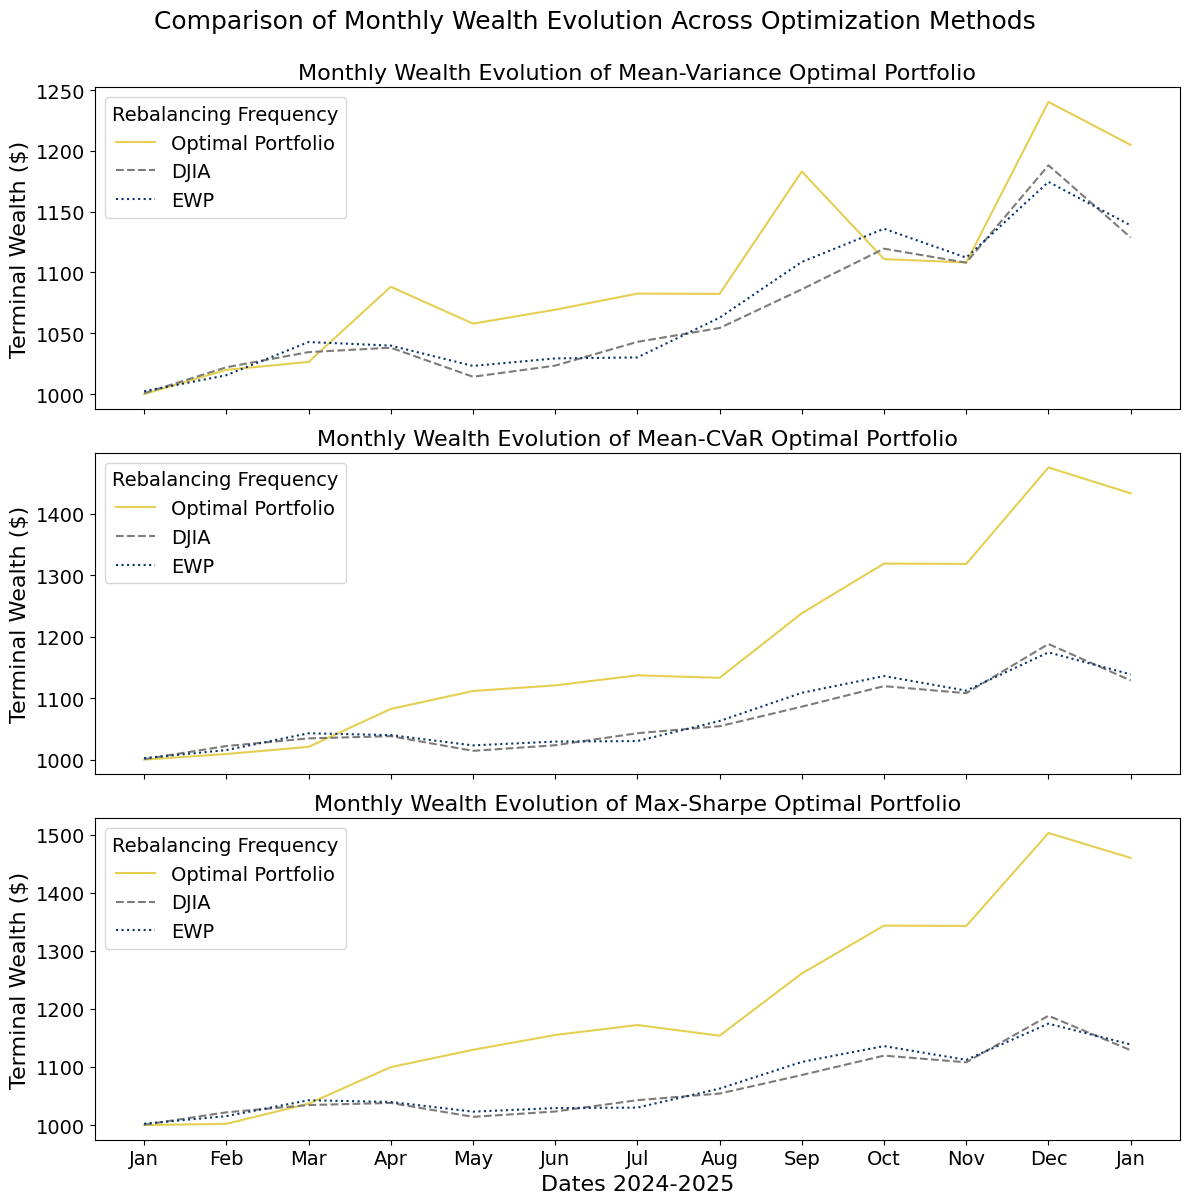

In [52]:
print("Terminal Wealth Summary for different rebalancing frequencies:")
tw_df.columns = ['Yearly Return (2024)'] #["M", "B", "Q", "S", "Y"]

# Convert terminal wealth to percentage return
initial_wealth = 1000
tw_df_percent = tw_df.copy()
tw_df_percent['Yearly Return (2024)'] = (tw_df['Yearly Return (2024)'] - initial_wealth) / initial_wealth * 100

# Custom color function
def color_terminal_wealth(val, djia_val, ewp_val, max_val):
    if val > djia_val and val > ewp_val:
        color = '#99FF99'  # Light green
        font = 'black'
        if val == max_val:
            color = 'green' 
            font = 'white'
    elif val < djia_val and val < ewp_val:
        color = '#FF9999'  # Light red
        font = 'black'
    else:
        color = '#FFFF99'  # Light yellow
        font = 'black'
    
    return f'background-color: {color}; color: {font}'

# Apply black background for DJIA and Equally Weighted Portfolio rows
styled_df = tw_df_percent.style.applymap(lambda x: 'background-color: black; color: white', 
                                 subset=pd.IndexSlice[['Equally Weighted Portfolio', 'DJIA'], :])

# Apply color formatting for all other rows
def apply_color_formatting(col):
    djia_val = tw_df_percent.loc['DJIA', col.name]
    ewp_val = tw_df_percent.loc['Equally Weighted Portfolio', col.name]
    max_val = col.max()

    return col.apply(lambda x: color_terminal_wealth(x, djia_val, ewp_val, max_val))

styled_df = styled_df.apply(apply_color_formatting, axis=0, 
                            subset=pd.IndexSlice[tw_df_percent.index.difference(['Equally Weighted Portfolio', 'DJIA']), :])
# Display the terminal wealth summary
display(styled_df.format("{:.1f}%"))

# Plot the evolution of terminal wealth for different rebalancing frequencies and compare with EWP and DJIA
djia_monthly_cum = djia_returns_test_cum.iloc[::21].values
djia_monthly_cum = np.append(djia_monthly_cum, djia_returns_test_cum.iloc[-1])
ewp_monthly_cum = cum_wealth_ewp.iloc[::21].values
ewp_monthly_cum = np.append(ewp_monthly_cum, cum_wealth_ewp[-1])

num_methods = len(opt_methods)

# Create a single figure with multiple subplots
fig, axes = plt.subplots(num_methods, 1, figsize=(12, 4 * num_methods), sharex=True)

# Generate subplots for each optimization method
for ax, opt_method in zip(axes, opt_methods):
    monthly_wealths = monthly_wealths_dict[opt_method]
    
    # Plot the evolution of terminal wealth for different rebalancing frequencies
    for col in monthly_wealths.columns:
        ax.plot(monthly_wealths.index, monthly_wealths[col], color=cmap(0.9), label=f'Optimal Portfolio')
    
    # Plot benchmarks
    ax.plot(djia_monthly_cum, color=cmap(0.5), label='DJIA', linestyle='dashed')
    ax.plot(ewp_monthly_cum, color=cmap(0.1), label='EWP', linestyle='dotted')
    
    # Set labels and title
    ax.set_ylabel('Terminal Wealth ($)', fontsize=16)
    ax.tick_params(axis='y', labelsize=14)
    ax.set_title(f'Monthly Wealth Evolution of {opt_method} Optimal Portfolio', fontsize=16)
    ax.legend(title='Rebalancing Frequency', fontsize=14, title_fontsize=14)
    
# Set x-axis labels
months = pd.date_range(start='2024-01-01', periods=13, freq='M')
axes[-1].set_xticks(range(13))
axes[-1].set_xticklabels([month.strftime('%b') for month in months], fontsize=14)
axes[-1].set_xlabel('Dates 2024-2025' , fontsize=16)

# Set global title
fig.suptitle('Comparison of Monthly Wealth Evolution Across Optimization Methods', fontsize=18, y=1)

# Display plot
plt.tight_layout()
plt.savefig('test_performance.png', dpi=300)
plt.show()



In [30]:
# Get Monthly Values of VXD in out of sample horizon
vxd_month_test = vxd_series_interpolated[-252:].resample('M').last()
# Monthly volatility analysis in out of sample data
volatility_analysis_table = pd.DataFrame(index=['Volatility'], columns=vxd_month_test.index.strftime('%Y-%m'))

# Calculate volatilities for each month and store in the DataFrame
for date, value in vxd_month_test.items():
    vol = sgo.volatility_evaluation(value, 15.7, upper_quantile)
    volatility_analysis_table.loc['Volatility', date.strftime('%Y-%m')] = vol

# Convert the column names to month names
volatility_analysis_table.columns = pd.to_datetime(volatility_analysis_table.columns).strftime('%B')

# Display the updated volatility analysis table
print(volatility_analysis_table)

           January February March April  May June July August September  \
Volatility     low      low   low   low  low  low  low    low    medium   

           October November December  
Volatility     low      low   medium  


C:\Users\stefa\AppData\Local\Temp\ipykernel_25472\3705596905.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  vxd_month_test = vxd_series_interpolated[-252:].resample('M').last()
